# 1. 구글 드라이브 연동
Google Colab을 사용하므로 데이터를 구글 드라이브에 올렸다.<br>
따라서 데이터를 사용하기 위해 구글 드라이브와 연동한다.

In [0]:
from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# 2. 데이터 전처리 및 데이터 셋 설정
사진의 크기(픽셀)가 같아야 각 층의 커널을 통과한 후 
출력 벡터의 크기가 같아지는데 사진의 크기가 모두 다르다.<br>
따라서, 사진의 픽셀을 224*224 로 바꾼다.<br>
(구글 드라이브에서 변경하려고 하니 오래걸려서 로컬에서 미리 사진의 크기를 바꾸는 전처리를 했다.)<br>
<br>
그리고 데이터를 각각 training set과 test set으로 나눈다.<br>

In [0]:
from PIL import Image
import os, glob, numpy as np

caltech_dir = "/content/gdrive/My Drive/shuffled_chest_xray2/"
categories = ["NORMAL", "PNEUMONIA"]
nb_classes = len(categories)

image_w = 224
image_h = 224

pixels = image_h * image_w * 3

X_train = []
y_train = []

for idx, cat in enumerate(categories):
    
    #one-hot 돌리기.
    label = [0 for i in range(nb_classes)]
    label[idx] = 1

    image_dir = caltech_dir + "train/" + cat
    files = glob.glob(image_dir+"/*.jpeg")
    print(cat, " 파일 길이 : ", len(files))
    for i, f in enumerate(files):
      img = Image.open(f)
      img = img.convert("RGB")
      img = img.resize((image_w, image_h))
      data = np.asarray(img)

      X_train.append(data)
      y_train.append(label)

      if i % 200 == 0:
        print(cat, i, "/", len(files), " : ", f)
    

X_train = np.array(X_train)
y_train = np.array(y_train)
# 셔플
shuf = np.arange(X_train.shape[0])
np.random.shuffle(shuf)

X_train = X_train[shuf]
y_train = y_train[shuf]

X_test = []
y_test = []

for idx, cat in enumerate(categories):
    
    #one-hot 돌리기.
    label = [0 for i in range(nb_classes)]
    label[idx] = 1

    image_dir = caltech_dir + "test/" + cat
    files = glob.glob(image_dir+"/*.jpeg")
    print(cat, " 파일 길이 : ", len(files))
    for i, f in enumerate(files):
        img = Image.open(f)
        img = img.convert("RGB")
        img = img.resize((image_w, image_h))
        data = np.asarray(img)

        X_test.append(data)
        y_test.append(label)

        if i % 200 == 0:
            print(cat, i, "/", len(files), " : ", f)

X_test = np.array(X_test)
y_test = np.array(y_test)
# 셔플
shuf = np.arange(X_test.shape[0])
np.random.shuffle(shuf)

X_test = X_test[shuf]
y_test = y_test[shuf]

xy = (X_train, y_train, X_test, y_test)
print("change sets to list ok")
np.save("/content/gdrive/My Drive/np/shuffled_data.npy", xy)
print("총 파일 수: ", len(y_train)+len(y_test))

NORMAL  파일 길이 :  4572
NORMAL 0 / 4572  :  /content/gdrive/My Drive/shuffled_chest_xray2/train/NORMAL/00022390_000.jpeg
NORMAL 200 / 4572  :  /content/gdrive/My Drive/shuffled_chest_xray2/train/NORMAL/00024527_000.jpeg
NORMAL 400 / 4572  :  /content/gdrive/My Drive/shuffled_chest_xray2/train/NORMAL/00026181_004.jpeg
NORMAL 600 / 4572  :  /content/gdrive/My Drive/shuffled_chest_xray2/train/NORMAL/00027912_005.jpeg
NORMAL 800 / 4572  :  /content/gdrive/My Drive/shuffled_chest_xray2/train/NORMAL/00029840_000.jpeg
NORMAL 1000 / 4572  :  /content/gdrive/My Drive/shuffled_chest_xray2/train/NORMAL/00015561_008.jpeg
NORMAL 1200 / 4572  :  /content/gdrive/My Drive/shuffled_chest_xray2/train/NORMAL/00016861_002.jpeg
NORMAL 1400 / 4572  :  /content/gdrive/My Drive/shuffled_chest_xray2/train/NORMAL/00018027_005.jpeg
NORMAL 1600 / 4572  :  /content/gdrive/My Drive/shuffled_chest_xray2/train/NORMAL/00019363_004.jpeg
NORMAL 1800 / 4572  :  /content/gdrive/My Drive/shuffled_chest_xray2/train/NORMAL/000

# 3. 필요한 모듈 임포트
딥러닝 모델을 설계할 때 필요한 모듈들을 임포트 한다.<br>
그리고 2번에서 전처리한 데이터를 불러온다.<br>
데이터가 잘 섞여있나 확인을 위해 test set의 y값을 출력해본다.

In [0]:
%tensorflow_version 1.x

import os, glob, numpy as np
import PIL
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Activation, BatchNormalization, ZeroPadding2D, InputLayer
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import keras.backend.tensorflow_backend as K
import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

X_train, y_train, X_test, y_test= np.load("/content/gdrive/My Drive/np/shuffled_data.npy", allow_pickle = True)
print("is shuffled?: ")
print(y_test[:20])
print("training set shape: " + str(X_train.shape))
print("training set size: " + str(X_train.shape[0]))

is shuffled?: 
[[1 0]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]]
training set shape: (9135, 224, 224, 3)
training set size: 9135


# 4. RGB 값 일반화
RGB 값은 0\~255의 크기를 가지는데<br>
학습하기 위해선 0~1의 크기이어야 한다.<br>
따라서 크기를 바꿔준다.

In [0]:
categories = ["NORMAL", "PNEUMONIA"]
nb_classes = len(categories)

#일반화
X_train = X_train.astype(float) / 255
X_test = X_test.astype(float) / 255

# 5. 모델 설계
with 라인은 GPU를 사용하기 위한 코드다.<br>
모델의 구조는 밑의 6번에서 출력을 보면 알 수 있다.<br>
validation loss값이 가장 낮은 것을 최종 모델의 형태로 하는데<br>
학습 중 local optimum에 빠지는 것을 방지하기 위해<br>
현재 가장 낮은 val_loss 값보다 큰 loss 값이 나와도 7번까지 더 학습을 수행한다.<br>
7번까지 더 낮은 loss 값이 나오지 않으면 저장하고 있던 가장 낮은 loss 값으로 모델을 정의한다.

In [0]:
with K.tf_ops.device('/device:GPU:0'):
  model = Sequential()
  model.add(InputLayer(input_shape=X_train.shape[1:]))
  
  model.add(ZeroPadding2D(3))
  model.add(Conv2D(32, (7,7), padding="valid", strides=(2,2)))
  model.add(BatchNormalization(axis=2))
  model.add(Activation('relu'))
  
  model.add(ZeroPadding2D(1))
  model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
  model.add(BatchNormalization(axis=2))
  model.add(Dropout(0.25))
  
  model.add(ZeroPadding2D(1))
  model.add(Conv2D(64, (3,3), padding="valid", strides=(2,2)))
  model.add(BatchNormalization(axis=2))
  model.add(Activation('relu'))
  model.add(Dropout(0.25))
 
  model.add(Conv2D(128, (3,3), padding="same", strides=(2,2)))
  model.add(BatchNormalization(axis=2))
  model.add(Activation('relu'))
  model.add(Dropout(0.25))

  model.add(Conv2D(256, (3,3), padding="same", strides=(2,2)))
  model.add(BatchNormalization(axis=2))
  model.add(Activation('relu'))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(nb_classes, activation='sigmoid')) # 분류할 클래스가 3개 이상이면 softmax
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) # 분류할 클래스가 3개 이상이면 categorical_crossentropy
  model_dir = '/content/gdrive/My Drive/model'

  if not os.path.exists(model_dir):
    os.mkdir(model_dir)

  model_path = model_dir + '/Xray_img_classification.model'
  checkpoint = ModelCheckpoint(filepath=model_path , monitor='val_loss', verbose=1, save_best_only=True)
  early_stopping = EarlyStopping(monitor='val_loss', patience=7)

# 6. 모델의 형태
출력에는 보이지 않지만 224*224 사이즈로 input을 한다음<br>
제로 패딩을 3의 사이즈로 한 것이다.

In [0]:
model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_47 (ZeroPaddi (None, 230, 230, 3)       0         
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 112, 112, 32)      4736      
_________________________________________________________________
batch_normalization_92 (Batc (None, 112, 112, 32)      448       
_________________________________________________________________
activation_76 (Activation)   (None, 112, 112, 32)      0         
_________________________________________________________________
zero_padding2d_48 (ZeroPaddi (None, 114, 114, 32)      0         
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
batch_normalization_93 (Batc (None, 56, 56, 32)      

# 7. 학습 및 학습과정 저장
모델을 학습시키고 학습과정을 그래프로 나타내기 위해 학습과정을 저장한다.<br>
학습 중에 training set의 일부(20%)를 validation set으로 이용하여 평가한다.<br>

In [0]:
history = model.fit(X_train, y_train, batch_size=64, epochs=100, validation_split=0.2, shuffle=True, callbacks=[checkpoint, early_stopping])

Train on 7308 samples, validate on 1827 samples
Epoch 1/100
7308/7308 [==============================] - 28s 4ms/step - loss: 1.2696 - acc: 0.7787 - val_loss: 0.4881 - val_acc: 0.8342

Epoch 00001: val_loss improved from inf to 0.48808, saving model to /content/gdrive/My Drive/model/Xray_img_classification.model
Epoch 2/100
7308/7308 [==============================] - 14s 2ms/step - loss: 0.4038 - acc: 0.8374 - val_loss: 0.4246 - val_acc: 0.8374

Epoch 00002: val_loss improved from 0.48808 to 0.42459, saving model to /content/gdrive/My Drive/model/Xray_img_classification.model
Epoch 3/100
7308/7308 [==============================] - 14s 2ms/step - loss: 0.3788 - acc: 0.8485 - val_loss: 0.3816 - val_acc: 0.8404

Epoch 00003: val_loss improved from 0.42459 to 0.38160, saving model to /content/gdrive/My Drive/model/Xray_img_classification.model
Epoch 4/100
7308/7308 [==============================] - 14s 2ms/step - loss: 0.3689 - acc: 0.8506 - val_loss: 0.3512 - val_acc: 0.8451

Epoch 000

# 8. 모델 테스트
test set으로 모델의 성능을 테스트 한다.

In [0]:
print("정확도 : %.4f" % (model.evaluate(X_test, y_test)[1]))

2282/2282 [==============================] - 3s 1ms/step
정확도 : 0.8604


# 9. 학습 과정
모델의 학습 과정을 그래프로 도사한다.<br>
train_loss는 점점 감소하지만 val_loss는 어느 순간 잘 감소하지 않고 오히려 증가하는 것을 볼 수 있다.<br>
따라서 overfitting이 일어나기 전에 checkpoint에서 학습을 중지한 것을 볼 수 있다.

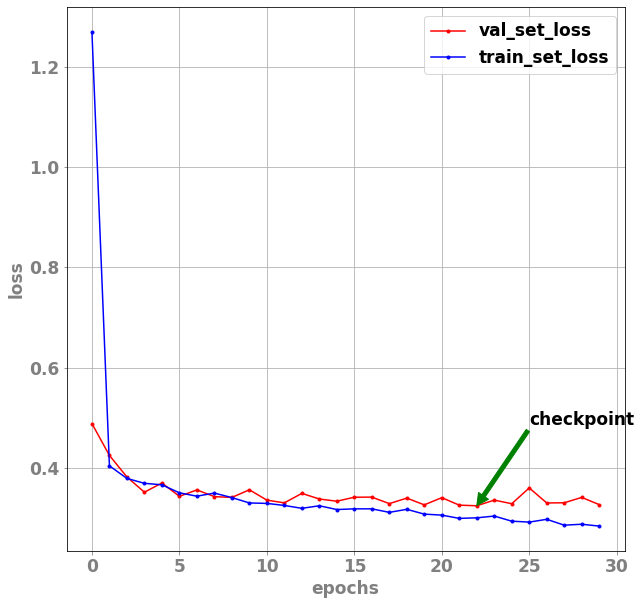

In [0]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']
x_len = np.arange(len(y_loss))

font = {'weight' : '600',
        'size'   : 17}
plt.rc('font', **font)
plt.rcParams['text.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'grey'
plt.rcParams['axes.labelweight'] = '600'
plt.rcParams['xtick.color'] = 'grey'
plt.rcParams['ytick.color'] = 'grey'
plt.figure(figsize=(10, 10))
plt.plot(x_len, y_vloss, marker='.', c='red', label='val_set_loss')
plt.plot(x_len, y_loss, marker='.', c='blue', label='train_set_loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.annotate('checkpoint',xy=(len(y_vloss)-8,y_vloss[len(y_vloss)-8]),xytext=(len(y_vloss)-5,y_vloss[len(y_vloss)-8]*1.5),arrowprops={'color':'green'},)
plt.show()

# 10. 사진 업로드로 테스트
실제 Chest X-ray 사진을 업로드하여 모델을 테스트 해본다.
### 10 - 1 사진 업로드
NORMAL 사진 3개와 PNEUMONIA 사진 3개를 순서대로 업로드한다.


Saving 00000137_000.png to 00000137_000 (8).png
Saving 00008641_001.png to 00008641_001 (8).png
Saving 00022639_001.png to 00022639_001 (8).png


Saving 00016434_001.png to 00016434_001 (24).png
Saving 00017652_000.png to 00017652_000 (21).png
Saving 00020322_007.png to 00020322_007 (20).png
User uploaded file "00000137_000.png" with length 437187 bytes
User uploaded file "00008641_001.png" with length 432445 bytes
User uploaded file "00022639_001.png" with length 427352 bytes
User uploaded file "00016434_001.png" with length 417319 bytes
User uploaded file "00017652_000.png" with length 425246 bytes
User uploaded file "00020322_007.png" with length 441029 bytes
['00000137_000.png', '00008641_001.png', '00022639_001.png', '00016434_001.png', '00017652_000.png', '00020322_007.png']
[(1024, 1024, 3), (1024, 1024, 3), (1024, 1024, 3), (1024, 1024, 3), (1024, 1024, 3), (1024, 1024, 3)]


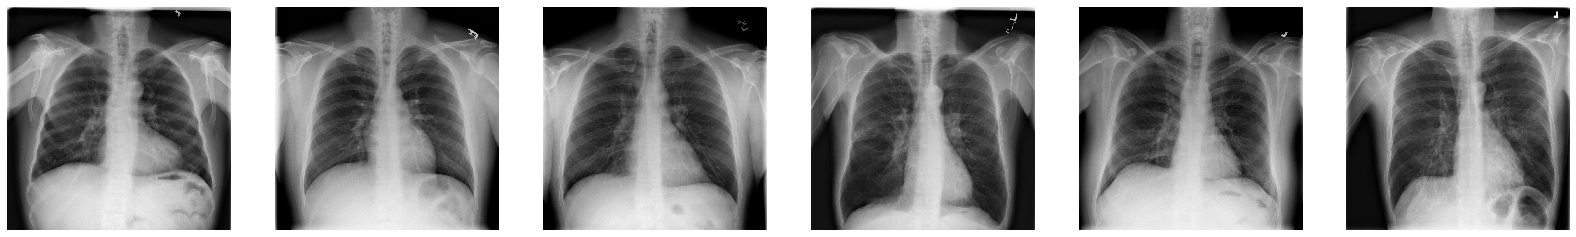

In [0]:
import cv2
from imageio import imread

from google.colab import files

uploaded = files.upload()
uploaded.update(files.upload())

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

imgs = []
shapes = []
real_data = ["NORMAL", "NORMAL", "NORMAL", "PNEUMONIA", "PNEUMONIA", "PNEUMONIA"]
fig = plt.figure(figsize=(28,28))

for i in range(6):
  img_fname = list(uploaded.keys())[i]
  imgs.append(cv2.imread(img_fname, cv2.IMREAD_COLOR))
  b, g, r = cv2.split(imgs[i])   # openCV는 rgb 순이 아니라 bgr 순이므로 img파일을 b,g,r로 분리
  imgs[i] = cv2.merge([r,g,b]) # b, r을 바꿔서 Merge
  shapes.append(img.shape)
  fig.add_subplot(1,6,i+1)
  plt.imshow(imgs[i])
  plt.axis('off')

print(list(uploaded.keys()))
print(shapes)

###10 - 2 predict 함수 정의
사진을 모델에 넣었을 때 나오는 결과 값을 리턴해주는 함수를 정의한다.

In [0]:
def predict(model, image, display=True):
  if display:
    plt.imshow(image[0])

  pred = model.predict(image)
  return categories[np.argmax(pred)]

### 10 - 3 사진 resize, predict 결과
모델의 input size인 224*224 크기로 사진을 바꾸고,<br>
사진을 tensor로 바꾼 다음에 모델에 넣는다.<br>
그리고 predict 결과를 출력한다.

[(1, 224, 224, 3), (1, 224, 224, 3), (1, 224, 224, 3), (1, 224, 224, 3), (1, 224, 224, 3), (1, 224, 224, 3)]
["'NORMAL' is predicted as 'NORMAL'", "'NORMAL' is predicted as 'NORMAL'", "'NORMAL' is predicted as 'NORMAL'", "'PNEUMONIA' is predicted as 'PNEUMONIA'", "'PNEUMONIA' is predicted as 'NORMAL'", "'PNEUMONIA' is predicted as 'PNEUMONIA'"]


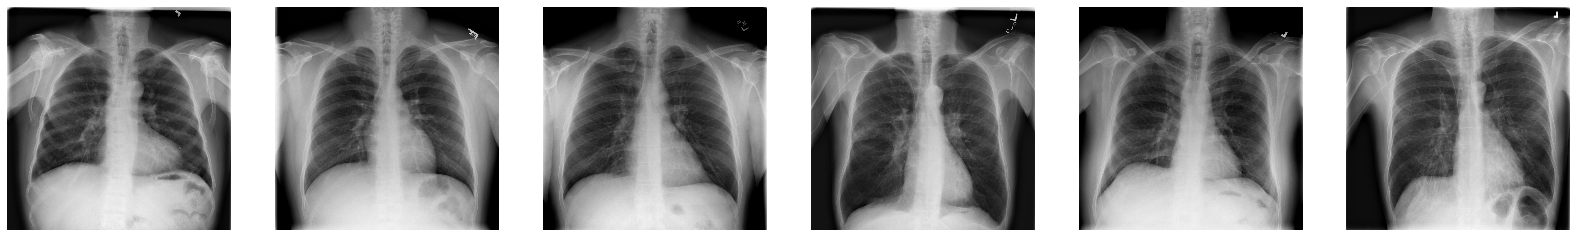

In [0]:
fig = plt.figure(figsize=(28,28))

img224s = []
shapes = []
pred = []
result = []

for i in range(6):
  img224s.append(cv2.resize(imgs[i], (224,224)))
  
  fig.add_subplot(1,6,i+1)
  plt.imshow(img224s[i])
  plt.axis('off')

  img224s[i] = np.expand_dims(img224s[i], axis=0)
  shapes.append(img224s[i].shape)
  pred.append(predict(model, img224s[i]))
  result.append('\''+real_data[i]+'\' is predicted as \''+pred[i]+'\'')

print(shapes)
print(result)

###10 - 4 heat map 생성
모델이 사진의 어느 부분을 보고 분류하는지 확인하기 위해 flatten층 전에 heat map을 만든다.

dropout_104
(128,)
(14, 14, 128)
2


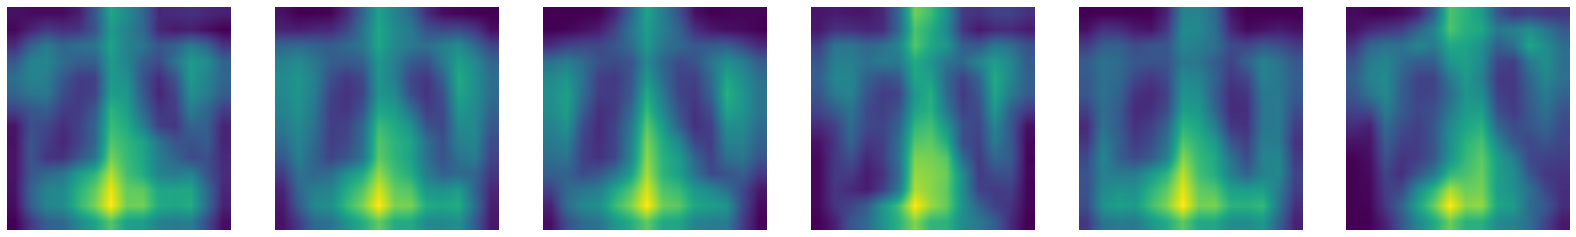

In [0]:
conv_layer = model.layers[-9]
print(model.layers[-9].name)
gradients = K.gradients(model.output, conv_layer.output)[0]
mean_gradients = K.mean(gradients, axis=(0,1,2))

extractor_fn = K.function([model.input], [mean_gradients, conv_layer.output[0]])
upsized_cam_images = []
fig = plt.figure(figsize=(28,28))
for i in range(6):
  mean_grad_vals, conv_output = extractor_fn([img224s[i]])        

  for j in range(14):
      conv_output[:, :, j] *= mean_grad_vals[j]

  heatmap = np.mean(conv_output, axis=-1)
  heatmap = np.maximum((heatmap), 0)
  heatmap /= np.max(heatmap)

  upsized_cam_images.append(cv2.resize(heatmap, imgs[i].shape[:2][::-1]))
  fig.add_subplot(1,6,i+1)
  plt.imshow(upsized_cam_images[i])
  plt.axis('off')

print(mean_grad_vals.shape)
print(conv_output.shape)
num_classes = model.layers[-1].output.shape[1]
print(num_classes)

### 10-5 X-ray와 heat map 합치기
예상했던 결과는 폐 쪽에 heat map이 나타나길 바랬지만<br>
안타깝게도 NORMAL(이하 정상)과 PNEUMONIA(이하 폐렴)의 heat map 사이에 구분되는 점은 폐렴인 사람은 목에 무언가 걸린다는 것이다.<br>
아래 사진을 보면 실제론 폐렴이지만 목에 heat map이 걸리지 않은 사진은 정상으로 판단되었다.<br>
폐 쪽에 heat map이 나타나지 않은 이유를 생각해보면,<br> 
지금 이 모델의 코드가 object detection(객체 감지)가 아니라 object recognition(객체 구별)로 만들었기 때문이라고 생각한다.<br>

["'NORMAL' is predicted as 'NORMAL'", "'NORMAL' is predicted as 'NORMAL'", "'NORMAL' is predicted as 'NORMAL'", "'PNEUMONIA' is predicted as 'PNEUMONIA'", "'PNEUMONIA' is predicted as 'NORMAL'", "'PNEUMONIA' is predicted as 'PNEUMONIA'"]


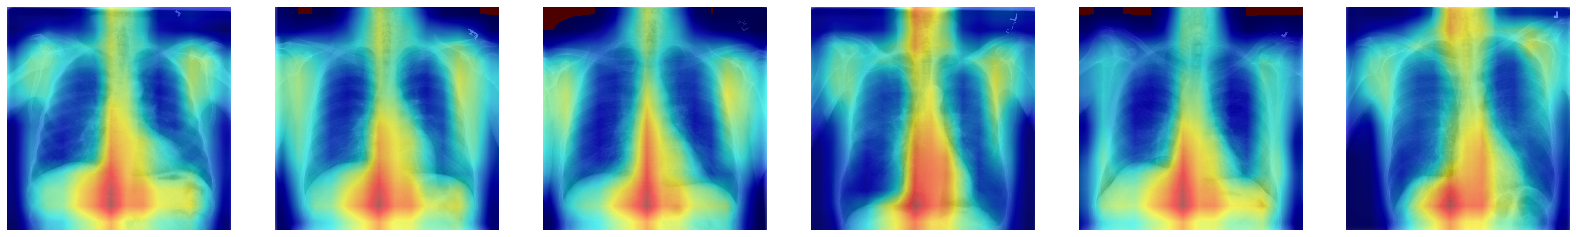

In [0]:
fig = plt.figure(figsize=(28,28))
applied_imgs = []
for i in range(6):
  applied_imgs.append(cv2.applyColorMap(np.uint8(-255*upsized_cam_images[i]), cv2.COLORMAP_JET))  # cv2.COLORMAP_HSV
  fig.add_subplot(1,6,i+1)
  plt.imshow(imgs[i])
  plt.axis('off')
  plt.imshow(applied_imgs[i], alpha=0.6)

print(result)

# 11. Review
폐렴 사진은 5704장 뿐인데 정상 사진은 약 6만개가 넘었다.<br>
따라서 랜덤하게 정상 사진에서 5704개의 사진을 두 그룹으로 뽑았다.(A그룹, B그룹)<br>
정상, 폐렴 각각 5704장의 사진중에서 랜덤하게 20%(1141장)의 사진을 test set을 위해 분리했다.<br>
A그룹의 정상 사진과 폐렴 사진을 사용한 모델은 평균적으로 88%의 정확도를 나타냈다.<br>
B그룹의 정상 사진과 폐렴 사진을 사용한 모델은 평균적으로 85%의 정확도를 나타냈다.<br>
모델의 평균 정확도는 약 86% 정도로 볼 수 있으므로 꽤 유능한 분류 성능을 보여준다.<br>
<br>
전이 학습을 사용한 모델중에선 VGG16을 사용한 모델이 가장 적합했다.<br>
하지만 직접 만든 CNN 모델에 비해 오히려 성능은 낮게 나왔다고 볼 수 있다..<br>
왜냐하면 비슷한 정확도지만 VGG16을 사용한 모델의 loss값은 0.35 고, 직접 만든 CNN 모델의 loss값은 0.32 정도로<br>
미세하지만 직접 설계한 간단한 CNN 모델이 더 좋다고 생각한다.<br>
<br>
그리고 모델이 사진의 어느 부분을 보고 분류하는지 알아보기 위해 heat map을 추가해봤지만<br>
객체 탐지가 아니라 객체 분류 모델이라 폐렴인 부분을 발견하진 못했다.<br>
폐렴인 부분을 찾는 것이 더 좋은 기능이라고 생각하므로, 객체 탐지로 폐렴을 탐지하는 모델을 만들어야 할 것 같다.
<br>
<br>
### 전이 학습에 히트맵이 없는 이유
히트맵을 만들려면 특징 추출의 마지막 층을 분류기의 출력 층으로 미분하여 gradients 값을 구해야 되는데,<br>
전이 학습을 사용한 모델은 특징 추출기가 가중치를 동결시키고 분류기와 연결시켜서<br> 
두 layer사이에 gradients가 연관되어있지 않아서 히트맵을 만들 수 없었다.